# Movie Recommendation Engine

We want to perform UV-decomposition to impute missing values in the recommendation matrix. This approach is described in chapter 9 of Yure Leskovic's textbook: http://infolab.stanford.edu/~ullman/mmds/ch9.pdf. 

The algorithm is as follows:
1. Demean movie ratings both within each user and within each movie
2. Perform UV-decomposition on the resulting matrix
3. Multiply the resulting matrices to get the imputed ratings
4. Use cosine similarity of rating columns to find movies which are similar

In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt
import tqdm

# Set the random seed
np.random.seed(0)

# Set up tqdm for pandas
tqdm.tqdm.pandas()

In [2]:
# Read in the ratings data
ratings = pd.read_csv('../raw/ratings.csv')

# Let's enumerate the users so we can use them as indices
users = ratings['userId'].unique()
users = pd.DataFrame(users, columns=['userId'])
users['user_index'] = users.index

# Let's enumerate the movies so we can use them as indices
movies = ratings['movieId'].unique()
movies = pd.DataFrame(movies, columns=['movieId'])
movies['movie_index'] = movies.index

# Merge the ratings with the enumerated users and movies
ratings = pd.merge(ratings, users, on='userId')
ratings = pd.merge(ratings, movies, on='movieId')

First, let's standardize the movie ratings

In [3]:
# Demean the ratings by user
user_means = ratings.groupby('user_index')['rating'].mean()
user_sd = ratings.groupby('user_index')['rating'].std()
ratings = ratings.merge(user_means, on='user_index', suffixes=('', '_mean'))
ratings = ratings.merge(user_sd, on='user_index', suffixes=('', '_sd'))
ratings['rating'] = ratings['rating'] - ratings['rating_mean']
ratings['rating'] = ratings['rating'] / ratings['rating_sd']
ratings = ratings.drop(columns=['rating_mean', 'rating_sd'])

# Demean the ratings by movie
movie_means = ratings.groupby('movie_index')['rating'].mean()
movie_sd = ratings.groupby('movie_index')['rating'].std()
ratings = ratings.merge(movie_means, on='movie_index', suffixes=('', '_mean'))
ratings = ratings.merge(movie_sd, on='movie_index', suffixes=('', '_sd'))
ratings['rating'] = ratings['rating'] - ratings['rating_mean']
ratings['rating'] = ratings['rating'] / ratings['rating_sd']
ratings = ratings.drop(columns=['rating_mean', 'rating_sd'])

# If ratings are missing, drop them
# This occurs due to users who only view one movie
# and so have no standard deviation
ratings = ratings.dropna(subset=['rating'])

# Split into training and test sets
# Note: really I should probably do some cluster randomizing by either user or movie???
train = ratings.sample(frac = 0.95)
test = ratings.drop(train.index)

Next, let's convert the long data into a matrix

In [4]:
# Convert the long data into a matrix
# Note we need to use coo_matrix since it's best for iterating over the data and populating
# the predictions matrix
ratings_matrix = sparse.coo_matrix((train['rating'], (train['user_index'], train['movie_index'])))

With our matrix in hand, we can try to perform UV-decomposition

In [5]:
UV_DIM = 10
TOL = 1

# Initialize U and V
U = np.random.rand(ratings_matrix.shape[0], UV_DIM)
V = np.random.rand(ratings_matrix.shape[1], UV_DIM)

# Train the model
error = 1e100
improvement = np.inf
counter = 0
while improvement > TOL:

    old_error = error

    # Note that the actual contraction is *much* faster than the error checking, so let's run this
    # a bunch of times before checking the error
    for i in range(10):
        # Update U
        U = ratings_matrix @ V @ np.linalg.inv(V.T @ V)

        # Update V
        V = ratings_matrix.T @ U @ np.linalg.inv(U.T @ U)

    # Implement matrix multiplication as a map
    matrix_generator = [U[i] @ V[j] for i, j in zip(ratings_matrix.row, ratings_matrix.col)]
    predictions = sparse.coo_matrix((matrix_generator, (ratings_matrix.row, ratings_matrix.col)), shape=ratings_matrix.shape)

    # Compute the error for each element of the matrix, then compute SSE
    error_matrix = ratings_matrix - predictions
    error_vec = error_matrix.data
    error = np.linalg.norm(error_vec)

    improvement = old_error - error

    print(improvement)


1e+100
0.741907900377555


Let's compare the true results against the imputed results out-of-sample

In [6]:
# Construct a ground-truth matrix for the test set
test_matrix = sparse.coo_matrix((test['rating'], (test['user_index'], test['movie_index'])))

# Compute the predictions for the test set
test_predictions = sparse.lil_matrix((test_matrix.shape[0], test_matrix.shape[1]))
for i, j, v in tqdm.tqdm(zip(test_matrix.row, test_matrix.col, test_matrix.data), total=len(test_matrix.data)):
    test_predictions[i, j] = U[i] @ V[j]

true_ratings = test_matrix.data
predicted_ratings = np.array([U[i] @ V[j] for i, j in zip(test_matrix.row, test_matrix.col)])


100%|██████████| 1248691/1248691 [00:04<00:00, 309547.93it/s]


In [7]:
# Create a data frame of the true and predicted ranking with their indices
predictions_df = pd.DataFrame({
    'true': true_ratings, 
    'predicted': predicted_ratings,
    'user_index': test_matrix.row,
    'movie_index': test_matrix.col
})

# For each movie, count how many reviews there are in the training sample
movie_counts = train.groupby('movie_index').size()
movie_counts = pd.DataFrame(movie_counts, columns=['count'])

# Merge the counts with the movie counts
predictions_df_w_counts = predictions_df.merge(movie_counts, left_on='movie_index', right_index=True, suffixes=('', '_count'))

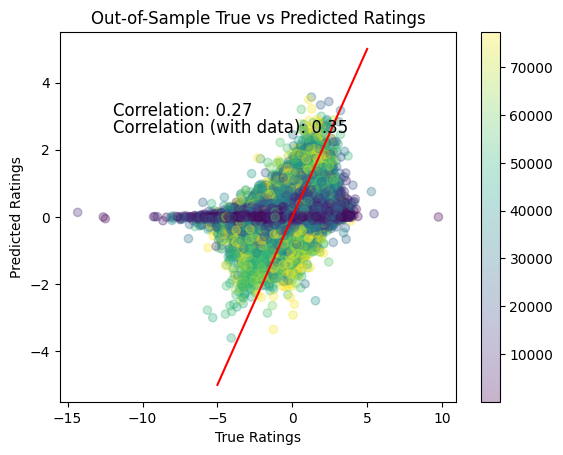

In [8]:
# Scatter the true ratings against the predicted ratings with some transparency
plt.scatter(predictions_df_w_counts['true'], predictions_df_w_counts['predicted'], alpha=0.3, c = predictions_df_w_counts['count'])
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Out-of-Sample True vs Predicted Ratings')

# Add legend for color
plt.colorbar()

# Add a line for the identity
plt.plot([-5, 5], [-5, 5], color='red')

# Add correlation to the plot
correlation = np.corrcoef(predictions_df['true'], predictions_df['predicted'])[0, 1]
# Add correlation for those with counts above threshold
correlation_w_data = np.corrcoef(
    predictions_df_w_counts['true'][predictions_df_w_counts['count'] > 10000], 
    predictions_df_w_counts['predicted'][predictions_df_w_counts['count'] > 10000]
)[0, 1]
plt.text(-12, 3, f'Correlation: {correlation:.2f}', fontsize=12)
plt.text(-12, 2.5, f'Correlation (with data): {correlation_w_data:.2f}', fontsize=12)
plt.show()

Once we have the predicted rankings for each movie, we want to find the pairwise similarities for each movie in our Guru data. 

In [13]:
# Load the tmdb data
# Note we should merge *before* doing the cross-join so we can propogate movie-level results
tmdb = pd.read_parquet('../../tmdb/embeddings/movie_descriptions.parquet')
tmdb = tmdb['tmdb_id'].unique()
tmdb = pd.DataFrame(tmdb, columns=['tmdb_id'])

# Now let's read in the TMDB-MovieLens mapping
tmdb_movielens_xwalk = pd.read_csv('../raw/links.csv')

# Drop the IMDB ids
tmdb_movielens_xwalk = tmdb_movielens_xwalk.drop(columns=['imdbId'])

# Now we can merge on the movie indices
full_xwalk = movies.merge(
    tmdb_movielens_xwalk, 
    on='movieId', 
    how='left',
    validate='one_to_one'
    )

# If there are any missing TMDB ids, drop them
full_xwalk = full_xwalk.dropna(subset=['tmdbId'])

# For duplicates in TMDB ID, keep only the first
# These seem to be related to some IMDB movies having multiple IDs;
# only true for ~40 movies
full_xwalk = full_xwalk.drop_duplicates(subset='tmdbId')

# Next we can merge the indices onto the tmdb data
tmdb = tmdb.merge(full_xwalk, left_on='tmdb_id', right_on='tmdbId', validate='one_to_one')
tmdb = tmdb.drop(columns=['tmdb_id'])

# Finally we can compute the predicted review vectors for each movie
tmdb['reviews'] = tmdb['movie_index'].apply(lambda x: U[x] @ V.T)
tmdb['review_norm'] = tmdb['reviews'].apply(lambda x: np.linalg.norm(x))

Now that we've projected out reviews for each movie, we want to compute the pairwise similarity between each *pair* of movies using the cosine similarity. 

In [14]:
# Create each possible pair of movies
tmdb_pairs = tmdb.merge(tmdb, how='cross')

# Drop self-pairs
tmdb_pairs = tmdb_pairs[tmdb_pairs['tmdbId_x'] != tmdb_pairs['tmdbId_y']]

# Include each pair only once
tmdb_pairs = tmdb_pairs[tmdb_pairs['tmdbId_x'] < tmdb_pairs['tmdbId_y']]

Now that we've produced the TMDB pairs, we want to compute the similarity between each pair of movies under our UV-decomposition model. 

In [16]:
def compute_similarity(row):
    # Get the movie vectors
    movie_x_vec = row['reviews_x']
    movie_y_vec = row['reviews_y']

    movie_x_norm = row['review_norm_x']
    movie_y_norm = row['review_norm_y']

    # Compute the cosine similarity
    similarity = np.dot(movie_x_vec, movie_y_vec) / (movie_x_norm * movie_y_norm)
    return similarity

# Compute the similarity for each pair
tmdb_pairs['similarity'] = tmdb_pairs.progress_apply(compute_similarity, axis=1)

  0%|          | 101/5026035 [00:01<15:05:05, 92.55it/s]C:\Users\gmoor\AppData\Local\Temp\ipykernel_29568\4049714483.py:10: RuntimeWarning: invalid value encountered in scalar divide
  similarity = np.dot(movie_x_vec, movie_y_vec) / (movie_x_norm * movie_y_norm)
100%|██████████| 5026035/5026035 [15:49<00:00, 5292.44it/s]  


Once we have the similarity measures, we'll save them to a file linked to their TMDB IDs.

In [18]:
# Drop all but the keys and the similarities
tmdb_pairs_trimmed = tmdb_pairs[['tmdbId_x', 'tmdbId_y', 'similarity']]

# Write the results to disk
tmdb_pairs_trimmed.to_csv('../output/UV_decomp_similarity.csv', index=False)